# 필요 라이브러리

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.formula.api import ols
from tqdm import tqdm
%matplotlib inline

# 기상 데이터

In [ ]:
os.getcwd()

'/home/user301/홍성민/빅리더 CNN'

In [ ]:
df_1 = pd.read_csv("./csv데이터/7월30일기상데이터.csv",encoding='cp949')
df_2 = pd.read_csv("./csv데이터/7월31일기상데이터.csv",encoding='cp949')
df_3 = pd.read_csv("./csv데이터/8월1일기상데이터.csv",encoding='cp949')
df_4 = pd.read_csv("./csv데이터/8월2일기상데이터.csv",encoding='cp949')
df_5 = pd.read_csv("./csv데이터/8월3일기상데이터.csv",encoding='cp949')
df_6 = pd.read_csv("./csv데이터/8월4일기상데이터.csv",encoding='cp949')
df_7 = pd.read_csv("./csv데이터/8월5일기상데이터.csv",encoding='cp949')
df_8 = pd.read_csv("./csv데이터/8월6일기상데이터.csv",encoding='cp949')
df_9 = pd.read_csv("./csv데이터/8월7일기상데이터.csv",encoding='cp949')
df_10 = pd.read_csv("./csv데이터/8월8일기상데이터.csv",encoding='cp949')
df_11 = pd.read_csv("./csv데이터/8월9일기상데이터.csv",encoding='cp949')
df_12 = pd.read_csv("./csv데이터/8월10일기상데이터.csv",encoding='cp949')

In [ ]:
os.chdir('./죽전세월교마스킹')

In [ ]:
df_sort = []
files = glob.glob('*.png')
for f in files:
    df_sort.append(f)
df_sort.sort()

In [ ]:
#필요한 데이터 시작점
index_7 = df_1[df_1['일시'] == '2022-07-30 10:34'].index[0]
df_1 = df_1.iloc[index_7:,:]

#필요한 데이터 끝점
index_8 = df_12[df_12['일시'] == df_sort[-1].split(".")[0]].index[0]
df_12 = df_12.iloc[:index_8+1,:]

#데이터 결합
df = pd.concat([df_1, df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12])

In [ ]:
#결측치 대체
df['1분 강수량(mm)'] = df['1분 강수량(mm)'].fillna(0)

In [ ]:
#누적강수량
def rainsum(minute):
    rainfall = []
    rain = 0
    for i in range(len(df)):
        try:
            for j in range(i-minute,i):
                rain += df['1분 강수량(mm)'].iloc[j]
            rainfall.append(rain)
            rain = 0
        except:
            rainfall.append(0)
    return rainfall

#누적강수유무
def raincount(minute):
    raincount = []
    rain = 0
    for i in range(len(df)):
        try:
            for j in range(i-minute,i):
                if df['강수유무(유무)'].iloc[j] == 0:
                    rain += 0
                else:
                    rain += 1
            raincount.append(rain)
            rain = 0
        except:
            raincount.append(0)
    return raincount

#기온평균
def tempmean(minute):
    templist = []
    temp = 0
    for i in range(len(df)):
        try:
            for j in range(i-minute,i):
                temp += df['기온(°C)'].iloc[j]
            tempmean = temp/minute
            templist.append(tempmean)
            temp = 0
        except:
            templist.append(0)
    return templist

In [ ]:
rain60 = rainsum(60)
rain15 = rainsum(15)
rain30 = rainsum(30)
rain90 = rainsum(90)
rain120 = rainsum(120)

raincount60 = raincount(60)
raincount15 = raincount(15)
raincount30 = raincount(30)
raincount90 = raincount(90)
raincount120 = raincount(120)

temp120 = tempmean(120)

df["누적강수량 60분"] = rain60
df["누적강수량 120분"] = rain120
df["누적강수량 90분"] = rain90
df["누적강수량 30분"] = rain30
df["누적강수량 15분"] = rain15

df["누적강수유무 60분"] = raincount60
df["누적강수유무 120분"] = raincount120
df["누적강수유무 90분"] = raincount90
df["누적강수유무 30분"] = raincount30
df["누적강수유무 15분"] = raincount15

df['기온평균'] = temp120

# 침수면적

In [ ]:
# 물 면적 픽셀값 추출
def get_pixel(img_size_x = 1920, img_size_y = 1080):
    date = []
    pixel = []
    for i in tqdm(glob.glob('*.png')):
        img = cv2.imread(i,0)
        img_resize = cv2.resize(img,(img_size_x,img_size_y))
        unique, counts = np.unique(img_resize,return_counts=True)
        pix = dict(zip(unique,counts))[255]
        date.append(i.split(".")[0])
        pixel.append(pix)
    df_pix = pd.DataFrame({'일시':date,f'픽셀{img_size_x}':pixel})
    return df_pix

In [ ]:
pixel300 = get_pixel(300,300)
pixel200 = get_pixel(200,200)
pixel100 = get_pixel(100,100)
pixel50 = get_pixel(50,50)

100%|██████████| 6010/6010 [00:48<00:00, 123.82it/s]


In [ ]:
df_final = pd.merge(df,pixel50,how='left',on='일시')
df_final = pd.merge(df_final,pixel100,how='left',on='일시')
df_final = pd.merge(df_final,pixel200,how='left',on='일시')
df_final = pd.merge(df_final,pixel300,how='left',on='일시')

In [ ]:
# null값 열 제거
df_final = df_final.drop(['현지기압(hPa)','해면기압(hPa)'],axis=1)

In [ ]:
# null값 행 제거
df_final = df_final.dropna(axis=0)
df_final.shape

(5859, 24)

In [ ]:
#칼럼명 알아보기 쉽게 변경
df_final.columns = ['지점','지점명' ,'일시', '기온', '분_강수량', '강수유무', '풍향', '풍속',
       '습도', '누적강수량_60분', '누적강수량_120분', '누적강수량_90분', '누적강수량_30분',
       '누적강수량_15분', '누적강수유무_60분', '누적강수유무_120분', '누적강수유무_90분', '누적강수유무_30분',
       '누적강수유무_15분','기온평균', '픽셀50', '픽셀100', '픽셀200', '픽셀300']

### 이상치 제거

In [ ]:
# 물면적 오류난 데이터
outlier = ['용인_죽전_세월교-220731_09-15-00.png',
'용인_죽전_세월교-220731_09-26-00.png',
'용인_죽전_세월교-220731_09-40-00.png',
'용인_죽전_세월교-220731_10-27-00.png',
'용인_죽전_세월교-220731_12-49-00.png',
'용인_죽전_세월교-220731_14-46-00.png',
'용인_죽전_세월교-220731_14-55-00.png',
'용인_죽전_세월교-220731_15-02-00.png',
'용인_죽전_세월교-220801_13-43-00.png',
'용인_죽전_세월교-220801_16-46-00.png',
'용인_죽전_세월교-220801_18-39-00.png',
'용인_죽전_세월교-220801_18-48-00.png',
'용인_죽전_세월교-220802_11-43-00.png',
'용인_죽전_세월교-220802_11-49-00.png',
'용인_죽전_세월교-220802_11-50-00.png',
'용인_죽전_세월교-220802_11-51-00.png',
'용인_죽전_세월교-220802_11-53-00.png',
'용인_죽전_세월교-220802_12-11-00.png',
'용인_죽전_세월교-220802_12-20-00.png',
'용인_죽전_세월교-220802_12-54-00.png',
'용인_죽전_세월교-220802_13-04-00.png',
'용인_죽전_세월교-220802_13-05-00.png',
'용인_죽전_세월교-220803_11-08-00.png',
'용인_죽전_세월교2-220804_17-54-00.png',
'용인_죽전_세월교2-220805_14-22-00.png',
'용인_죽전_세월교2-220805_14-49-00.png',
'용인_죽전_세월교2-220805_14-50-00.png',
'용인_죽전_세월교2-220805_14-54-00.png',
'용인_죽전_세월교2-220805_15-05-00.png',
'용인_죽전_세월교2-220805_15-18-00.png',
'용인_죽전_세월교2-220805_15-19-00.png',
'용인_죽전_세월교2-220805_15-44-00.png',
'용인_죽전_세월교2-220805_16-06-00.png',
'용인_죽전_세월교2-220805_17-47-00.png',
'용인_죽전_세월교2-220806_08-56-00.png',
'용인_죽전_세월교2-220806_11-38-00.png',
'용인_죽전_세월교2-220806_11-40-00.png',
'용인_죽전_세월교2-220806_11-41-00.png',
'용인_죽전_세월교2-220806_11-42-00.png',
'용인_죽전_세월교2-220806_11-43-00.png',
'용인_죽전_세월교2-220806_11-44-00.png',
'용인_죽전_세월교2-220806_11-45-00.png',
'용인_죽전_세월교2-220806_11-46-00.png',
'용인_죽전_세월교2-220806_11-50-00.png',
'용인_죽전_세월교2-220807_15-01-00.png',
'용인_죽전_세월교2-220808_17-57-00.png',
'용인_죽전_세월교2-220809_18-09-00.png',
'용인_죽전_세월교2-220809_18-44-00.png',
'용인_죽전_세월교2-220809_18-45-00.png',
'용인_죽전_세월교2-220809_18-46-00.png']

In [ ]:
#이상치 데이터 이름을 데이터프레임의 일시와 형식이 같게 변경
outlier_rename = [] 
for i in outlier:
    last_name = i.split("-")[2]
    first_name = i.split("-")[1].split("_")[1]
    middle_name = i.split("-")[1].split("_")[0]
    middle_name = [middle_name[j:j+2] for j in range(0, len(middle_name), 2)]
    full_name = "20" + middle_name[0] + "-" + middle_name[1] + "-" +middle_name[2] + " " + first_name+":"+last_name
    outlier_rename.append(full_name)

In [ ]:
#인덱스로 이상치 제거
outlier_idx = []
for i in range(len(outlier_rename)):
    outlier_idx.append(df_final[df_final['일시'] == outlier_rename[i]].index[0])

In [ ]:
df_final = df_final.drop(outlier_idx,axis=0)
len(df_final)

5809

In [ ]:
#인덱스 초기화
df_final = df_final.reset_index(drop=True)

# 상관관계 히트맵 시각화

/home/user301/.local/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


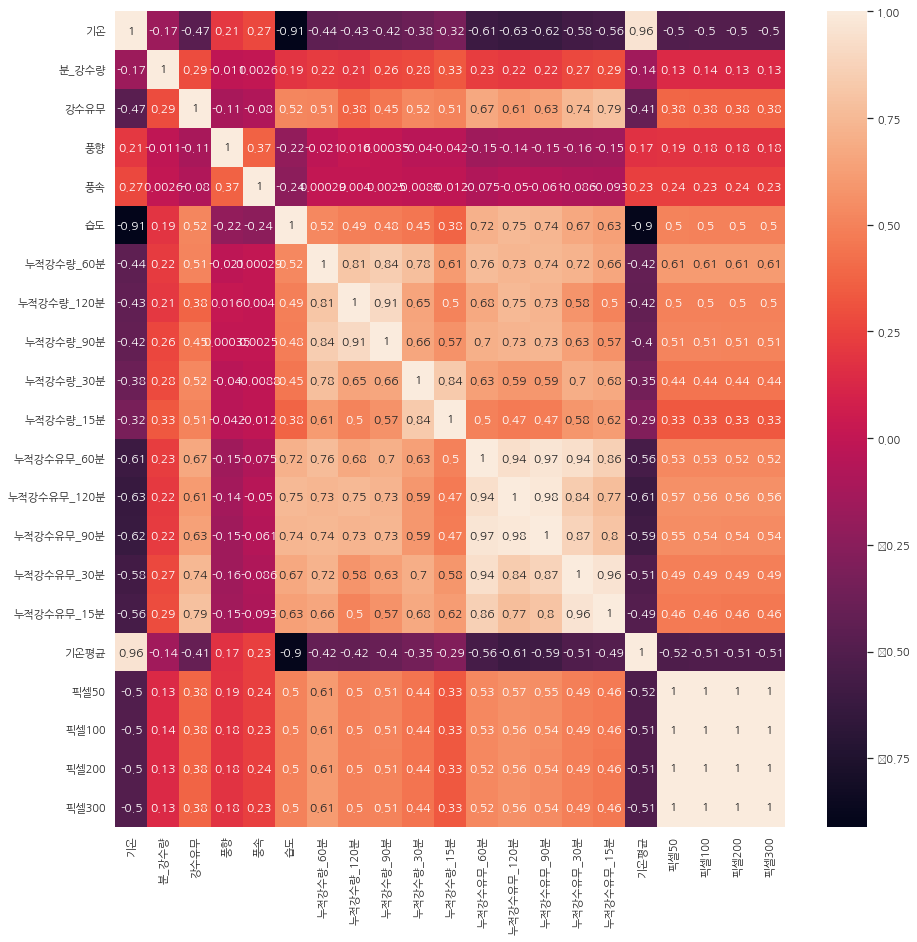

In [ ]:
#plt.rcParams['font.family'] = 'NanumGothic'
plt.rc('font', family='NanumGothic')
sns.set(font="NanumGothic",rc = {'figure.figsize':(15,15)})
sns.heatmap(df_final.iloc[:,3:].corr(),annot=True)

In [ ]:
feature = ['픽셀50','기온평균','누적강수량_120분','풍향','풍속','습도','누적강수유무_120분','누적강수유무_15분']

/home/user301/.local/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


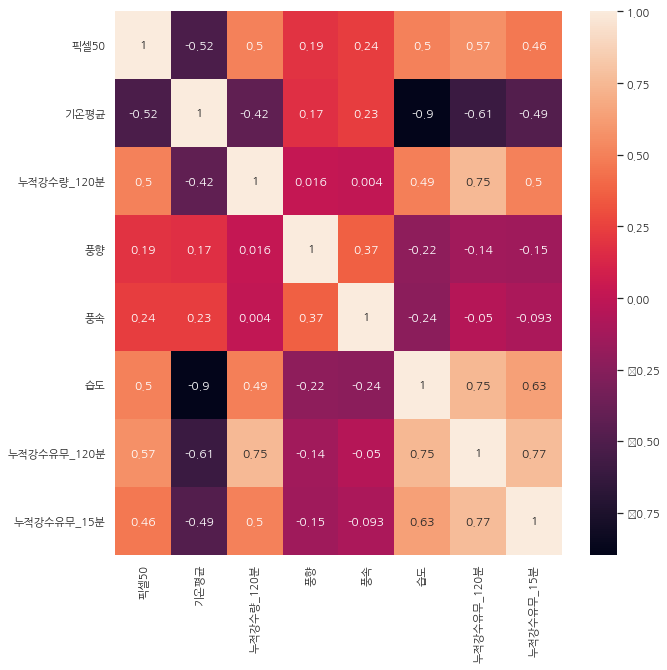

In [ ]:
plt.rc('font', family='NanumGothic')
sns.set(font="NanumGothic",rc = {'figure.figsize':(10,10)})
sns.heatmap(df_final[feature].corr(),annot=True)

---

## p-value 확인

In [ ]:
model = ols('픽셀50 ~' + "+".join(['기온평균','누적강수량_120분','풍향','풍속','습도','누적강수유무_120분','누적강수유무_15분']), df_final)

In [ ]:
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   픽셀50   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     943.5
Date:                Thu, 25 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:23:37   Log-Likelihood:                -31983.
No. Observations:                5809   AIC:                         6.398e+04
Df Residuals:                    5801   BIC:                         6.403e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     644.3167     32.176     20.025      0.000     581.239     707.394
기온평균          -17.7165      0.734    -24.141      0.000     -19.155     -16.278
누적강수량_120분      2.3862      0.254      9.385      0.000       1.888       2.885
풍향              0.2225      0.012     18.755      0.000       0.199       0.246
풍속             24.9763      0.920     27.139      0.000      23.172      26.780
습도             -1.0828      0.176     -6.157      0.000      -1.428      -0.738
누적강수유무_120분     0.5710      0.061      9.394      0.000       0.452       0.690
누적강수유무_15분      2.7410      0.276      9.945      0.000       2.201       3.281
==============================================================================
Omnibus:                     5838.027   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           637750.405
Skew:                           4.690   Prob(JB):                         0.00
Kurtosis:                      53.467   Cond. No.                     8.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

p-value가 0.05 이하임을 알 수 있다.

## 다중공선성 확인

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')

,컬럼,VIF
0,기온평균,5.459619
1,누적강수량_120분,2.485596
2,풍향,1.220116
3,풍속,1.248020
4,습도,8.236300
5,누적강수유무_120분,5.994249
6,누적강수유무_15분,2.596337


vif지수가 10이하임을 알 수 있다.  

p-value, 다중공선성 모두 만족 

## 최종 변수 시각화

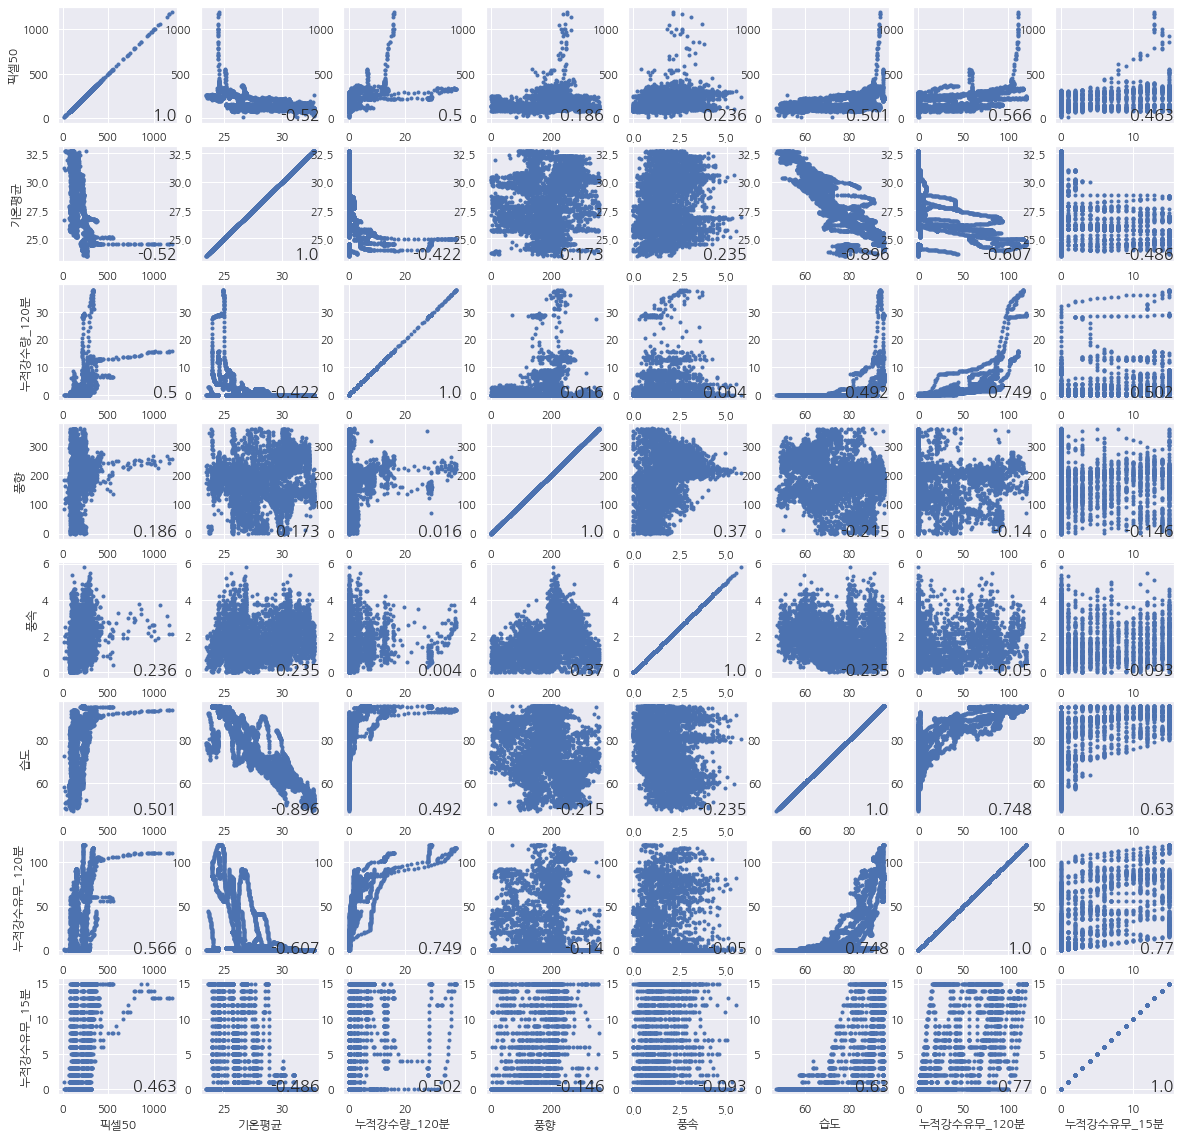

In [ ]:
feature = ['픽셀50','기온평균','누적강수량_120분','풍향','풍속','습도','누적강수유무_120분','누적강수유무_15분']

corr_feature = df_final[feature].corr()

fig = plt.figure(figsize=(20,20))

n_feature = len(feature)
for i in range(n_feature):
    for j in range(n_feature):
        ax = fig.add_subplot(n_feature,n_feature,i*n_feature + j + 1)
        plt.scatter(feature[j],feature[i],data=df_final,s=9)
        
        if i == n_feature-1:
            plt.xlabel(feature[j],fontsize=12)
        if j==0:
            plt.ylabel(feature[i],fontsize=12)
        ax.annotate(np.round(corr_feature.loc[feature[i],feature[j]],3),xy=(1,0), xycoords='axes fraction',
                   fontsize =16, horizontalalignment='right',verticalalignment='bottom')
        
plt.show()

---

# 머신러닝

# 필요 라이브러리

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#교차검증과 평가 함수 생성

def cv_model(model,X_train,y_train):
    kfold = KFold(n_splits=4)
    cv_r2 = []
    n_iter = 0
    for train_idx, vali_idx in kfold.split(X_train,y_train):
        X_train1, X_vali1 = X_train[train_idx], X_train[vali_idx]
        y_train1, y_vali1 = y_train.iloc[train_idx], y_train.iloc[vali_idx]
        
        model.fit(X_train1,y_train1)
        
        pred = model.predict(X_vali1)
        
        n_iter += 1
        r2 = r2_score(y_vali1, pred)
        print(f'\n{n_iter} 교차검증 정확도 : {r2}, 학습데이터 크기 : {X_train1.shape[0]}, 검증데이터 크기 : {X_vali1.shape[0]}')
        cv_r2.append(r2)
    print('\n')
    print('\n 평균검증 정확도 : ', np.mean(cv_r2))
    return np.mean(cv_r2)

In [ ]:
#머신러닝 평가 함수 생성
def PrintRegScore(y_true, y_pred):
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('r2_score: {}'.format(r2_score(y_true, y_pred)))

In [ ]:
#독립변수 Minmax화
#train-test 8:2비율로 split
df_X = df_final[['기온평균','누적강수량_120분','풍향','풍속','습도','누적강수유무_120분','누적강수유무_15분']]
df_Y = df_final['픽셀50']

scaler = MinMaxScaler()
df_X_scale = scaler.fit_transform(df_X)
X_train, X_test, y_train, y_test = train_test_split(df_X_scale, df_Y, test_size=0.2, random_state=42)

In [ ]:
#default 파라미터로 모델 생성
xgb = XGBRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)
cat = CatBoostRegressor(random_seed=17,silent=True)
kn = KNeighborsRegressor()
sgd = SGDRegressor(random_state=0)
dt =DecisionTreeRegressor(random_state=0)
lgbm = LGBMRegressor(random_state=0)
svr = SVR()
gbr = GradientBoostingRegressor(random_state=0)

In [ ]:
models = {'XGBoost':xgb,'RandomForest':rf,'Catboost':cat,'KNeighbors':kn,'SGD':sgd,'DecisionTree':dt,'Lightgbm':lgbm,'SVR':svr,'GradientBoostingReg':gbr}

In [ ]:
#default 파라미터 모델 교차검증 결과확인
results = {}
for i in models:
    print(f'------------------------{i}결과 출력------------------------')
    result = cv_model(models[i],X_train,y_train)
    results[i] = result
print('정확도가 가장 높은 모델은 ', max(results,key=results.get),'입니다.')

------------------------XGBoost결과 출력------------------------

1 교차검증 정확도 : 0.8967490067951397, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

2 교차검증 정확도 : 0.9551260931250071, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

3 교차검증 정확도 : 0.9531932971273807, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

4 교차검증 정확도 : 0.9295470792691662, 학습데이터 크기 : 3486, 검증데이터 크기 : 1161



 평균검증 정확도 :  0.9336538690791735
------------------------RandomForest결과 출력------------------------

1 교차검증 정확도 : 0.9218744132082285, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

2 교차검증 정확도 : 0.9444810322075767, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

3 교차검증 정확도 : 0.9588077744170179, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

4 교차검증 정확도 : 0.9400982569659564, 학습데이터 크기 : 3486, 검증데이터 크기 : 1161



 평균검증 정확도 :  0.9413153691996948
------------------------Catboost결과 출력------------------------

1 교차검증 정확도 : 0.9540811327748988, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

2 교차검증 정확도 : 0.9527895778098266, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

3 교차검증 정확도 : 0.9557419393930899, 학습데이터 크기 : 3485, 검증데이터 크기 : 1162

4 교

In [ ]:
#모델 결과 데이터프레임 생성
df_result = pd.DataFrame([results]).T
df_result.columns = ['r2_score']

In [ ]:
df_result = df_result.sort_values('r2_score')

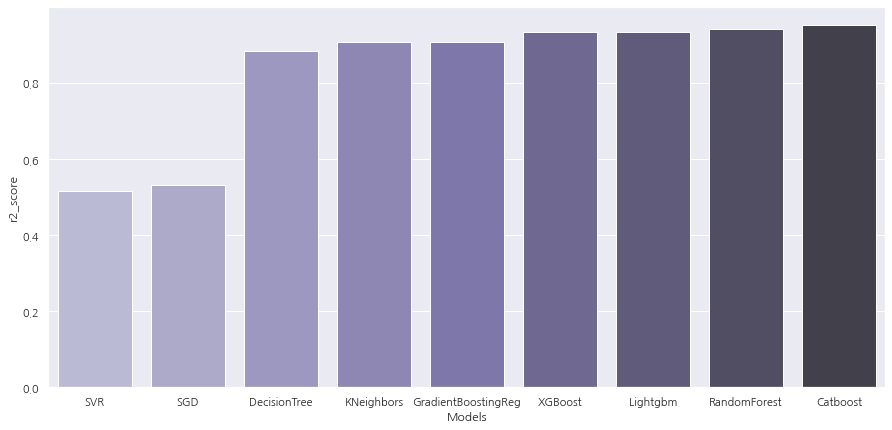

In [ ]:
#모델 결과 시각화
plt.figure(figsize=(15,7))
ax = sns.barplot(data=df_result.T,palette='Purples_d')
ax.set(xlabel='Models', ylabel='r2_score')
plt.show()

In [ ]:
# 최적의 파라미터 값 출력 함수 생성
# default 파라미터 모델 평가 결과 상위 5개모델 하이퍼파라미터 튜닝
def model_grid(reg,params):
    model = reg
    parameters = params
    grid = GridSearchCV(estimator=model, param_grid = parameters,cv=4, n_jobs=-1)
    grid.fit(X_train, y_train)
    print('final params', grid.best_params_)  
    print('best score', grid.best_score_)  
    return grid.best_params_

In [ ]:
cat_param = {'depth' : [6,8,10],
              'learning_rate' : [0.001,0.01, 0.05, 0.1],
              'iterations'    : [100,500,1000],
              'silent' : [True]}

cat_params = model_grid(cat,cat_param)

final params {'depth': 8, 'iterations': 1000, 'learning_rate': 0.05, 'silent': True}
best score 0.9550038217227774


In [ ]:
xgb_param = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.01, 0.05, .1], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}
xgb_params = model_grid(xgb,xgb_param)

[15:30:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:01] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


final params {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
best score 0.9454644968875435


In [ ]:
rf_param = {
    'n_estimators':[100,500,1000],
    'max_depth':[6,8,10],
    'min_samples_leaf':[8,12],
    'min_samples_split':[8,16]
}

rf_params = model_grid(rf,rf_param)

final params {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
best score 0.8886151198964486


In [ ]:
gbr_param = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }
gbr_params = model_grid(gbr,gbr_param)

final params {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.9}
best score 0.950767430185439


In [ ]:
lgbm_param = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.01],
    'max_depth': [6, 8],
}

lgbm_params = model_grid(lgbm,lgbm_param)

final params {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}
best score 0.9432242431145476


In [ ]:
#test셋으로 최종 평가 실시
cat = CatBoostRegressor(random_seed=17,depth = 8,iterations = 1000, learning_rate = 0.05,silent=True)
cat.fit(X_train,y_train)
pred = cat.predict(X_test)
PrintRegScore(y_test, pred)

RMSE: 16.81494730433718
r2_score: 0.9660127799747856


In [ ]:
xgb = XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05, max_depth= 6, min_child_weight= 4, n_estimators= 1000, nthread= 4, objective= 'reg:linear', silent= 1, subsample= 0.7)
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
PrintRegScore(y_test, pred)

[15:43:25] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:25] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 17.6825790419319
r2_score: 0.9624148889360308


In [ ]:
rf = RandomForestRegressor(max_depth= 6, n_estimators= 100,min_samples_leaf=8,min_samples_split=8,random_state=0)
rf.fit(X_train,y_train)
pred = rf.predict(X_test)
PrintRegScore(y_test, pred)

RMSE: 28.8477235264659
r2_score: 0.8999659813246588


In [ ]:
lgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 8, n_estimators = 1000,random_state=0)
lgbm.fit(X_train,y_train)
pred = lgbm.predict(X_test)
PrintRegScore(y_test, pred)

RMSE: 17.685161474448883
r2_score: 0.9624039099832072


In [ ]:
gbr = GradientBoostingRegressor(learning_rate=0.03,max_depth=6,n_estimators=1000,subsample=0.9,random_state=0)
gbr.fit(X_train,y_train)
pred = gbr.predict(X_test)
PrintRegScore(y_test, pred)

RMSE: 17.395258452788205
r2_score: 0.9636263910655282


In [ ]:
#VotingRegressor에 여러 모델 조합 확인
er = VotingRegressor([('cat', cat), ('xgb', xgb),('lgbm',lgbm),('gbr',gbr),('rf',rf)])
pred = er.fit(X_train, y_train).predict(X_test)
PrintRegScore(y_test, pred)

[15:43:54] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:54] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 17.452445289763066
r2_score: 0.963386841788796


In [ ]:
er = VotingRegressor([('cat', cat), ('xgb', xgb),('gbr',gbr)])
pred = er.fit(X_train, y_train).predict(X_test)
PrintRegScore(y_test, pred)

[15:44:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:39] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 16.591061829197262
r2_score: 0.9669118119461193


In [ ]:
er = VotingRegressor([('cat', cat), ('xgb', xgb),('lgbm',lgbm),('gbr',gbr)])
pred = er.fit(X_train, y_train).predict(X_test)
PrintRegScore(y_test, pred)

[15:46:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:38] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 16.54143774639223
r2_score: 0.9671094503398996


VotingRegressor (Catboost, XGBoost, Lightgbm, GradientBoostRegressor) 조합이 약 0.967로 제일 높은 것을 확인

---

# 임계값으로 다중분류 평가

In [ ]:
#보통-주의 임계값 마스킹사진
nor_ca = glob.glob('../new_careful/*.png')

#주의-위험 임계값 마스킹사진
ca_dan = glob.glob('../Threshold/Careful/*.png')

In [ ]:
#보통-주의 임계값 마스킹사진 픽셀 값 추출
normal_pixel = []
for i in nor_ca:
    img = cv2.imread(i,0)
    img_resize = cv2.resize(img,(50,50))
    unique, counts = np.unique(img_resize,return_counts=True)
    pix = dict(zip(unique,counts))[255]
    normal_pixel.append(pix)
    
#주의-위험 임계값 마스킹사진 픽셀 값 추출
careful_pixel = []
for i in ca_dan:
    img = cv2.imread(i,0)
    img_resize = cv2.resize(img,(50,50))
    unique, counts = np.unique(img_resize,return_counts=True)
    pix = dict(zip(unique,counts))[255]
    careful_pixel.append(pix)

In [ ]:
#픽셀 값 평균으로 임계값 설정
normal_pixel = np.mean(normal_pixel)
careful_pixel = np.mean(careful_pixel)

In [ ]:
#임계값으로 예측값 0,1,2로 다중분류
pred_eval = []
for i in pred:
    if i<= normal_pixel:
        pred_eval.append(0)
    elif i > normal_pixel and i <= careful_pixel:
        pred_eval.append(1)
    elif i > careful_pixel:
        pred_eval.append(2)

In [ ]:
#임계값으로 실제값 0,1,2로 다중분류
test_eval = []
for i in y_test:
    if i<= normal_pixel:
        test_eval.append(0)
    elif i > normal_pixel and i <= careful_pixel:
        test_eval.append(1)
    elif i > careful_pixel:
        test_eval.append(2)

In [ ]:
#분류 평가 척도 라이브러리
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#분류 정확도, 오차행렬 출력
print("정확도 : {:.3f}".format(accuracy_score(test_eval,pred_eval)))
print("오차 행렬 \n",confusion_matrix(test_eval,pred_eval))

정확도 : 0.972
오차 행렬 
 [[984  12   0]
 [ 14 123   5]
 [  0   2  22]]


In [ ]:
print(classification_report(test_eval,pred_eval))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       996
           1       0.90      0.87      0.88       142
           2       0.81      0.92      0.86        24

    accuracy                           0.97      1162
   macro avg       0.90      0.92      0.91      1162
weighted avg       0.97      0.97      0.97      1162



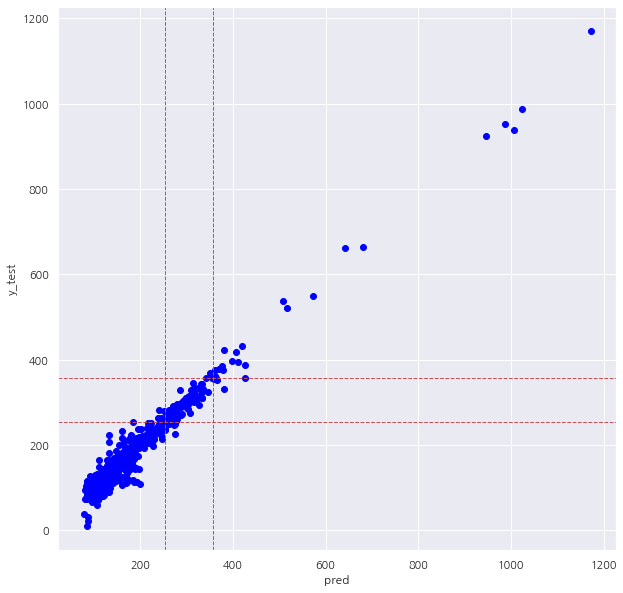

In [ ]:
#분류 평가 시각화
plt.figure(figsize=(10,10))
plt.xlabel('pred')
plt.ylabel('y_test')
plt.scatter(pred,y_test,color='blue',label='original',alpha=1)
plt.axhline(y=normal_pixel, color='r', linewidth=1,linestyle='--')
plt.axhline(y=careful_pixel, color='r', linewidth=1,linestyle='--')
plt.axvline(x=normal_pixel, color='r', linewidth=1,linestyle='--')
plt.axvline(x=careful_pixel, color='r', linewidth=1,linestyle='--')
plt.show()

---

# 15분, 30분, 60분 뒤 예측

In [ ]:
#예측으로 사용할 이미지
predictions = ['용인_죽전_세월교2-220805_15-15-00.jpg',
'용인_죽전_세월교2-220805_17-04-00.jpg',
'용인_죽전_세월교2-220806_07-50-00.jpg',
'용인_죽전_세월교2-220806_10-39-00.jpg',
'용인_죽전_세월교2-220806_11-39-00.jpg',
'용인_죽전_세월교2-220806_12-08-00.jpg',
'용인_죽전_세월교2-220806_12-12-00.jpg',
'용인_죽전_세월교2-220806_12-16-00.jpg',
'용인_죽전_세월교2-220809_05-50-00.jpg',
'용인_죽전_세월교2-220809_05-55-00.jpg',
'용인_죽전_세월교2-220809_06-05-00.jpg ',
'용인_죽전_세월교2-220809_06-11-00.jpg',
'용인_죽전_세월교2-220809_06-17-00.jpg',
'용인_죽전_세월교2-220809_09-54-00.jpg',
'용인_죽전_세월교2-220809_12-51-00.jpg',
'용인_죽전_세월교2-220809_13-45-00.jpg',
'용인_죽전_세월교2-220809_16-37-00.jpg']

In [ ]:
#이미지 일시에 맞게 rename
pred_rename = [] 
for i in predictions:
    last_name = i.split("-")[2]
    first_name = i.split("-")[1].split("_")[1]
    middle_name = i.split("-")[1].split("_")[0]
    middle_name = [middle_name[j:j+2] for j in range(0, len(middle_name), 2)]
    full_name = "20" + middle_name[0] + "-" + middle_name[1] + "-" +middle_name[2] + " " + first_name+":"+last_name
    pred_rename.append(full_name)

In [ ]:
pred_rename

['2022-08-05 15:15',
 '2022-08-05 17:04',
 '2022-08-06 07:50',
 '2022-08-06 10:39',
 '2022-08-06 11:39',
 '2022-08-06 12:08',
 '2022-08-06 12:12',
 '2022-08-06 12:16',
 '2022-08-09 05:50',
 '2022-08-09 05:55',
 '2022-08-09 06:05',
 '2022-08-09 06:11',
 '2022-08-09 06:17',
 '2022-08-09 09:54',
 '2022-08-09 12:51',
 '2022-08-09 13:45',
 '2022-08-09 16:37']

In [ ]:
#각 시간별 15분뒤, 30분뒤, 1시간뒤 일시 저장
import datetime
date_format = "%Y-%m-%d %H:%M"
pred_15 = []
pred_30 = []
pred_60 = []
for i in pred_rename:
    s_15 = str(datetime.datetime.strptime(i,date_format) + datetime.timedelta(minutes=15))
    pred_15.append(s_15.rsplit(":",1)[0])
    s_30 = str(datetime.datetime.strptime(i,date_format) + datetime.timedelta(minutes=30))
    pred_30.append(s_30.rsplit(":",1)[0])
    s_60 = str(datetime.datetime.strptime(i,date_format) + datetime.timedelta(hours=1))
    pred_60.append(s_60.rsplit(":",1)[0])

In [ ]:
#데이터 프레임 생성
df_pred_scale = pd.DataFrame(df_X_scale,index = df_final.set_index('일시').index,columns=['기온평균','누적강수량_120분','풍향','풍속','습도','누적강수유무_120분','누적강수유무_15분'])

In [ ]:
df_pred_15 = pd.DataFrame(index=df_pred_scale.loc[pred_15].index)

In [ ]:
df_pred_15['prediction'] = er.predict(df_pred_scale.loc[pred_15].to_numpy())

In [ ]:
df_pred_15['real_value'] = df_final.set_index('일시').loc[pred_15]['픽셀50'].to_numpy()

In [ ]:
df_pred_15

,prediction,real_value
일시,,
2022-08-05 15:30,123.749558,108.0
2022-08-05 17:19,134.050775,140.0
2022-08-06 08:05,167.863627,110.0
2022-08-06 10:54,121.419149,108.0
2022-08-06 11:54,187.615529,187.0
2022-08-06 12:23,213.980582,217.0
2022-08-06 12:27,209.169790,207.0
2022-08-06 12:31,207.497184,203.0
2022-08-09 06:05,861.986348,864.0


In [ ]:
df_pred_30 = pd.DataFrame(index=df_pred_scale.loc[pred_30].index)
df_pred_30['prediction'] = er.predict(df_pred_scale.loc[pred_30].to_numpy())
df_pred_30['real_value'] = df_final.set_index('일시').loc[pred_30]['픽셀50'].to_numpy()

In [ ]:
df_pred_30

,prediction,real_value
일시,,
2022-08-05 15:45,138.016899,136.0
2022-08-05 17:34,126.375140,121.0
2022-08-06 08:20,126.904367,117.0
2022-08-06 11:09,119.382283,111.0
2022-08-06 12:09,231.788917,233.0
2022-08-06 12:38,194.221610,197.0
2022-08-06 12:42,189.685150,191.0
2022-08-06 12:46,191.165471,192.0
2022-08-09 06:20,542.643768,544.0


In [ ]:
df_pred_60 = pd.DataFrame(index=df_pred_scale.loc[pred_60].index)
df_pred_60['prediction'] = er.predict(df_pred_scale.loc[pred_60].to_numpy())
df_pred_60['real_value'] = df_final.set_index('일시').loc[pred_60]['픽셀50'].to_numpy()

In [ ]:
df_pred_60

,prediction,real_value
일시,,
2022-08-05 16:15,138.101523,145.0
2022-08-05 18:04,123.076555,128.0
2022-08-06 08:50,135.014610,125.0
2022-08-06 11:39,135.951953,132.0
2022-08-06 12:39,191.359702,187.0
2022-08-06 13:08,178.445585,164.0
2022-08-06 13:12,182.828289,190.0
2022-08-06 13:16,176.363468,177.0
2022-08-09 06:50,369.803815,367.0


In [ ]:
os.chdir('../')

In [ ]:
# csv파일로 저장
# df_pred_15.to_csv('df_pred_15.csv',encoding='cp949')
# df_pred_30.to_csv('df_pred_30.csv',encoding='cp949')
# df_pred_60.to_csv('df_pred_60.csv',encoding='cp949')